7.7. Diagrama de Ojo para Señales Transmitidas con Diferentes Pulsos y Configuraciones de Canal y Filtro

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

<Figure size 640x480 with 0 Axes>

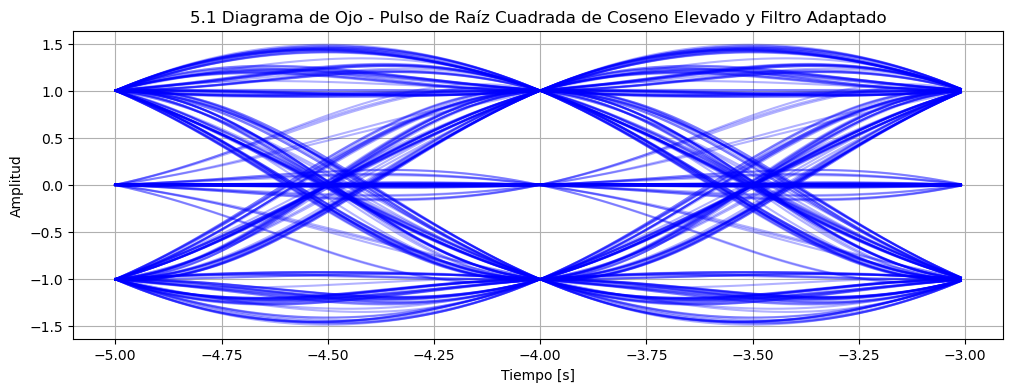

<Figure size 640x480 with 0 Axes>

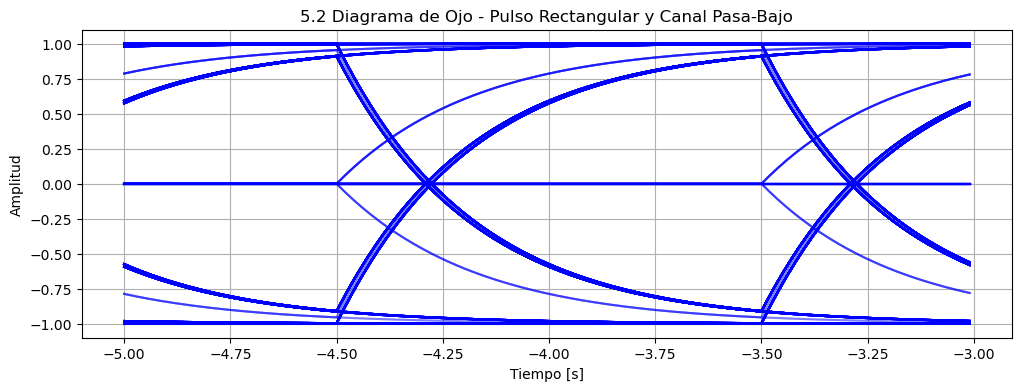

<Figure size 640x480 with 0 Axes>

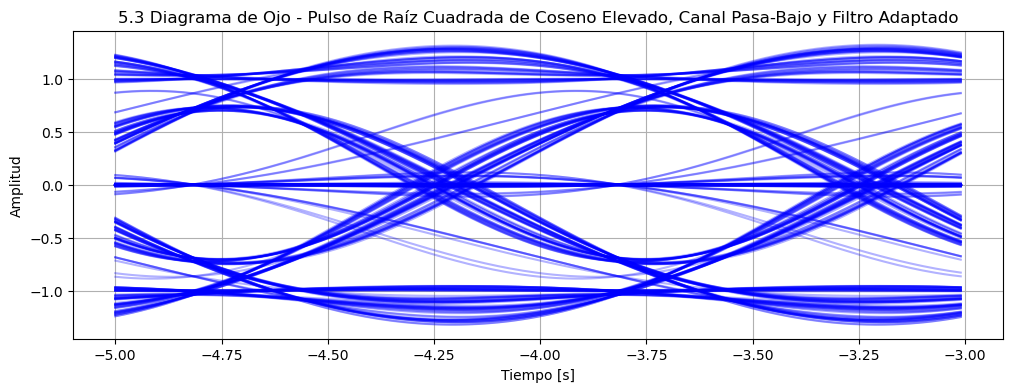

In [ ]:
# Parámetros generales
T = 1          # Duración del símbolo
alpha = 0.5    # Factor de roll-off
fs = 100       # Frecuencia de muestreo
N_bits = 50    # Número de bits transmitidos para generar el diagrama de ojo
fc = 0.5       # Frecuencia de corte para el canal pasa-bajo en Hz
desplazamiento = 5 * T  # Desplazamiento para centrar el tiempo en todas las señales

# Vector de tiempo común para todas las señales
t = np.arange(-desplazamiento, (N_bits + desplazamiento) * T, 1/fs)

# Función del pulso de raíz cuadrada de coseno elevado
def pulso_rrc(t, T, alpha):
    t = np.where(t == 0, 1e-20, t)  # Evitar división por cero
    pi_t = np.pi * t / T
    cuatro_alpha_t = 4 * alpha * t / T
    denominador = 1 - cuatro_alpha_t**2
    pulso = np.zeros_like(t)
    # Condición donde denominador != 0
    idx = np.abs(denominador) > 1e-10
    pulso[idx] = (np.sin(pi_t[idx] * (1 - alpha)) + cuatro_alpha_t[idx] * np.cos(pi_t[idx] * (1 + alpha))) / (pi_t[idx] * denominador[idx])
    # Condición donde denominador == 0
    idx = np.abs(denominador) <= 1e-10
    pulso[idx] = (np.pi / 4) * np.sinc(alpha * t[idx] / T)
    return pulso

# Función del pulso rectangular
def pulso_rectangular(t, T):
    return np.where(np.abs(t) <= T/2, 1, 0)

# Canal pasa-bajo de un polo
RC = 1 / (2 * np.pi * fc)
dt = 1 / fs
alpha_canal = dt / (RC + dt)
b_canal = [alpha_canal]
a_canal = [1, alpha_canal - 1]

# Generación de diagramas de ojo
def diagrama_ojo(funcion_pulso, canal=None, filtro_adaptado=False, es_rectangular=False):
    plt.figure(figsize=(12, 4))
    for _ in range(10):  # Repetimos varias transmisiones para formar el diagrama de ojo
        # Generación de bits aleatorios
        bits = np.random.choice([-1, 1], N_bits)

        # Señal transmitida
        s_t = np.zeros_like(t)
        for i, bit in enumerate(bits):
            if es_rectangular:
                s_t += bit * funcion_pulso(t - i * T, T)  # Sin alpha para el pulso rectangular
            else:
                s_t += bit * funcion_pulso(t - i * T, T, alpha)

        # Aplicación del canal, si existe
        if canal:
            s_t = lfilter(b_canal, a_canal, s_t)

        # Filtro adaptado, si es necesario
        if filtro_adaptado:
            h_rrc_t = pulso_rrc(t[::-1] - desplazamiento, T, alpha)
            s_t = np.convolve(s_t, h_rrc_t, mode='same') / fs

        # Recorte de la señal para cada bit y superposición en el diagrama de ojo
        for i in range(1, N_bits - 1):  # Evitamos bordes para mejor visualización del patrón de ojo
            indice_inicio = int((i * T - T) * fs)
            indice_final = indice_inicio + int(2 * T * fs)
            plt.plot(t[:2 * int(T * fs)], s_t[indice_inicio:indice_final], color='blue', alpha=0.3)

    plt.title("Diagrama de Ojo")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)

# 5.1 Pulso de Raíz Cuadrada de Coseno Elevado y Filtro Adaptado
plt.figure()
diagrama_ojo(pulso_rrc, filtro_adaptado=True)
plt.title("5.1 Diagrama de Ojo - Pulso de Raíz Cuadrada de Coseno Elevado y Filtro Adaptado")

# 5.2 Pulso Rectangular y Canal Pasa-Bajo
plt.figure()
diagrama_ojo(pulso_rectangular, canal=True, es_rectangular=True)
plt.title("5.2 Diagrama de Ojo - Pulso Rectangular y Canal Pasa-Bajo")

# 5.3 Pulso de Raíz Cuadrada de Coseno Elevado, Canal Pasa-Bajo y Filtro Adaptado
plt.figure()
diagrama_ojo(pulso_rrc, canal=True, filtro_adaptado=True)
plt.title("5.3 Diagrama de Ojo - Pulso de Raíz Cuadrada de Coseno Elevado, Canal Pasa-Bajo y Filtro Adaptado")

plt.show()
